# Importy

In [1]:
from Imports import *
from random_gen import *
import os
import pandas as pd
import seaborn as sns
R = RandomGen()

# Problem 7

## Zrozumienie i opis modelu
### Dzielenie pliku
Dzielenie pliku następuje według zasad opisanych w zadaniu. Dodatkowo gdy liczba podziałów $k \sim Poiss(\lambda)$ plik nie jest dzielony, a gdy wygenerowana liczba przedziałów $k$ przekracza długość pliku jest on dzielony na odcinki jednoelementowe.
### Wstawianie plików na dysk
Aby udało się uzyskać sensowne czasy wykonania przy zaimplementowanej metodzie przy wywołaniach funkcji ograniczono się do zapełnienia dysku na poziomie $40\%$. Pliki są najpierw dzielone, a następnie tworzona jest jedna lista zawierająca oba pliki. Lista ta jest segregowana tak, aby większe części zostały umieszczone na dysku jako pierwsze, co statystycznie ma szansę skrócić czas wykonywania programu. Następnie dla każdego elementu z listy wybierany jest losowy indeks z dysku. Zachodzi sprawdzanie warunków: czy elementy nie są ułożone w kolejności oraz czy jest wystarczająco dużo miejsca na ich umieszczenie. Jeżeli dany indeks nie gwarantuje spełnienia warunków losowanych jest nowy. Największa możliwa ilość takich losować wynosi $N \cdot 10$. Po tym czasie zapełnianie dysku zaczyna się od nowa. Istnieją oczywiście dużo lepsze algorytmy pozwalające na umieszczanie takich danych na dysku, jednak zdecydowałyśmy się na ten, aby zapewnić losowość umieszczania elementów.
### Zczytywanie danych z dysku (jeden plik)
Zczytywanie pliku z dysku w przypadku pojedynczego pliku rozpoczyna się od generowania losowych wartości indeksów aż do znalezienia indeksu za którym kryje się liczba $1$ lub $-1$ zapisana na dysku. Następnie program kończy się jeśli wielkość tego pliku wynosiła 1, lub kontunuuje operacje dla następnych wartości. Tak długo jak pod kolejnymi indeksami zapisane są kolejne wartości, wyszukiwanie odbywa sie po kolejnych indeksach. Kiedy przestaje tak być następuje powrót do losowego generowania.
### Zczytywanie danych z dysku (dwa pliki)
Omówię model który przyjęłam w sytuacji w której mamy dwa równoległe czytniki oraz jeden czytnik. W przypadku jednego czytnika zakładam, że pliki wczytywane są jeden po drugim, tz. gdy czytnik trafi na 1 lub -1 musi zakończyć wczytywanie pozostałych elementów z tego pliku, zanim rozpocznie zczytywanie drugiego. W moim modelu oznacza to więc, że możemy zczytać jeden plik z dysku, zamienić wartości tego pliku na zero i następnie z tak przygotowanego dysku zczytać drugi plik. Następnie sumujemy czasy potrzebne na zczytanie każdego z tych plików i otrzymujemy ogólny czas zczytywania dla jednego czytnika. Dla dwóch równoległych czytników biorę pod uwagę największą wartość z tych dwóch, ponieważ czas działania czytników jest w tym wypadku niezależny.



## Ilość miejsca zajmowanego przez pliki w katalogu głównym Pythona

In [8]:
def get_size(start_path = "C:\Program Files (x86)\Python38-32", scale=1, max_val=None):
    """Take optional start path, scale and max_value of filesize 
    that would be considered.. Return total size of all files in directory and sub
    directories as well as a list of sizes both multiplied by scale parameter."""
    size_list = []
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if not os.path.islink(fp):
                s = os.path.getsize(fp)
                if max_val:
                    if s <= max_val:
                        total_size += s*scale
                        size_list.append(s*scale)
                else:
                    total_size += s*scale
                    size_list.append(s*scale)
    return total_size, size_list

Ponieważ w katalogu pythona znajduje się zauważalna ilość plików o dużych wielkościach do celów analizy ogarniczymy się do plików o wielkości nie większej niż 10000 bajtów. 

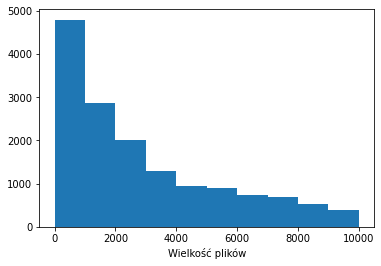

Łączna ilosć zajmowanego miejsca:  42831381 bytes


In [127]:
#Proszę o wpisanie ścieżki do plików w pythonie w wywołaniu funkcji

data = get_size(max_val=10000)
plt.hist(data[1])
plt.xlabel("Wielkość plików")
plt.show()
print("Łączna ilosć zajmowanego miejsca: ", data[0], 'bytes')

## Analiza czasu zczytywania plików z dysku

In [2]:
def part_file(l=1, m=10, neg=0):
    """Take argument lambda for poisson gnerator, m-number of bytes in file
    and neg. Generate number of slices from poisson distribution with l parameter.
    Slice at random points. If number of slices is greater than length of the list
    return list of lists of every element. Return list of slices."""
    k = R.random_poisson(l)
    c = 0
    if k >= m:
        if neg:
            return [[-i] for i in range(1, m+1)]
        else:
            return [[i] for i in range(1, m+1)]
    if k == 0:
        if neg:
            return [[-i] for i in range(1, m + 1)]
        else:
            return [list(range(1, m + 1))]
    ind = []
    count = 0
    while count < k:
        a = R.random_int(1, 1, m-1)
        if a not in ind:
            ind.append(a)
            count += 1
    ind.sort()
    part_list =[list(range(1, ind[0] + 1))] + [list(range(ind[i] + 1, ind[i+1] + 1)) for i in range(len(ind)-1)] + [list(range(ind[-1]+1, m + 1))]
    if neg:
        return [[-item for item in i] for i in part_list]
    return part_list

In [3]:
def put_on_drive(N, P1, P2=None):
    """Take size of a drive and put one or two sequenced files in a drive in a 
    random order. If number of tries to find a spot for a specific sequence is 
    greater than 10*N try from the begining. Return drive."""
    drive = np.zeros(N)
    if P2 != None:
        P = P1 + P2
    else:
        P = P1
    done = False
    while not done:
        drive = np.zeros(N)
        for i in P:
            checked = False
            count = 0
            while not checked and count <= 10*N:
                U = R.random_int(1, 0, len(drive))
 
                #sprawdzenie czy nie są ułożone w kolejności 
                correct = True
                if i[0] > 0:
                    if U > 0 and drive[U-1] + 1 == i[0] and i[0] != 1:
                        correct = False

                    elif U < N - len(i) and drive[U + len(i)] == i[-1] + 1:
                        correct = False

                else:
                    if U > 0 and drive[U-1] == i[0] + 1 and i[0] != -1:
                        correct = False

                    elif U < N - len(i) and drive[U + len(i)] == i[-1] - 1:
                        correct = False
                
                #sprawdzanie, czy jest wolne miejsce, jeśli jest to zamiana
                if all(x == 0 for x in drive[U:U + len(i)]) and U + len(i) < N and correct:
                    drive[U:U + len(i)] = i
                    checked = True
                count += 1
            if not checked:
                break 
        if checked:
            done = True
    return drive

In [9]:
def read_from_drive_one(drive):
    """Take drive. Read data from drive. Randomly search for starting position (either 1 or -1).
    Then untill positions are correct iterate drive. When they are not correct
    search randomly for another next position. This function read only one - 
    either positive or negative drive elements. Return number of searches."""
    U = np.random.randint(0, len(drive)-1)
    count = 0
    count += 1
    while drive[U] not in [-1, 1]:
        U = np.random.randint(0, len(drive)-1)
        count += 1
        if drive[U] == -1:
            drive *= -1
            break
    stop = abs(max(drive))
    if stop == 1:
        return count
    next_pos = 2
    if U < len(drive) - 1:
        U += 1
    else:
        U = np.random.randint(0, len(drive)-1)
    hist_data = []
    while drive[U] != stop or next_pos != stop:
        while next_pos == drive[U]:
            if next_pos == stop:
                return count
            if U < len(drive)-1:
                U += 1
            else:
                U = np.random.randint(0, len(drive)-1)
            count += 1
            next_pos += 1
        while next_pos != drive[U]:
            U = np.random.randint(0, len(drive)-1)
            count += 1

    return count

In [4]:
def read_from_drive(drive, both=True):
    """Take optional argument both - True if there are two readers. Read one file
    of a drive, multiply the drive by -1 and then read the second file. Return 
    either sum of counts (times) if there is only one reader and max of two counts
    if there are two."""
    count1 = read_from_drive_one(drive)
    drive2 = (-1) * np.where(drive < 0, drive, 0)
    count2 = read_from_drive_one(drive2)
    if both:
        return max(count1, count2)
    else:
        return count1 + count2

In [5]:
def hist_const_N(lambdas, N, df1=pd.DataFrame(), df2=pd.DataFrame(), dt=True):
    """Take list of argument lambdas for part file function,  N - len of 
    a drive, dt - if true will produce dataframe output. and optional DataFrames.
     Simulate a hundred of reading times for both one and two readers
    and then analyze the data in form of a cumulative disribution function, 
    histogram and basic statitics. Return a DataFrame of those statics."""

    times1 = []
    times2 = []
    for val in lambdas:
        P1 = part_file(m=int(N*0.2), l=val)
        P2 = part_file(neg=1, m=int(N*0.2), l=val)
        a = put_on_drive(N, P1, P2)
        temp1 = []
        temp2 = []
        for i in range(100):
            temp1.append(read_from_drive(a))
            temp2.append(read_from_drive(a, both=False))
        times1.append(temp1)
        times2.append(temp2)
        if dt:
            df1 = df1.append(pd.Series({"mean":np.mean(temp1), "var":np.var(temp1), 
                        "standard deviation" : np.sqrt(np.var(temp1)), "lambda" : val}), ignore_index=True)
            df2 = df2.append(pd.Series({"mean":np.mean(temp2), "var":np.var(temp2), 
                        "standard deviation" : np.sqrt(np.var(temp2)), "lambda": val}), ignore_index=True)

    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    for i in times1:
        plt.hist(i)
    plt.legend(lambdas)
    plt.title("Histogram dla jednego czytnika")
    plt.xlabel("Czas zczytywania")
 
    plt.subplot(1, 2, 2)
    for i in times2:
        plt.hist(i)
    
    plt.legend(lambdas)
    plt.legend(lambdas)
    plt.title("Histogram dla dwóch czytników")
    plt.xlabel("Czas zczytywania")
    plt.show()


    if dt:
        return df1, df2

In [15]:
def hist_const_l(N, l, df1=pd.DataFrame(), df2=pd.DataFrame(), dt=True):
    """Take list of argument N - sizes of a drie, argument lambda for part
    function, dt - if true will produce dataframe output. and optional DataFrames.
     Simulate a hundred of reading times for both one and two readers
    and then analyze the data in form of a cumulative disribution function, 
    histogram and basic statitics. Return a DataFrame of those statics."""
    times1 = []
    times2 = []
    for n in N:
        P1 = part_file(m=int(n*0.2), l=l)
        P2 = part_file(neg=1, m=int(n*0.2), l=l)
        a = put_on_drive(n, P1, P2)
        temp1 = []
        temp2 = []
        for i in range(100):
            temp1.append(read_from_drive(a))
            temp2.append(read_from_drive(a, both=False))
        times1.append(temp1)
        times2.append(temp2)
        if dt:
            df1 = df1.append(pd.Series({"mean":np.mean(temp1), "var":np.var(temp1), 
                        "standard deviation" : np.sqrt(np.var(temp1)), "N" : n}), ignore_index=True)
            df2 = df2.append(pd.Series({"mean":np.mean(temp2), "var":np.var(temp2), 
                         "standard deviation" : np.sqrt(np.var(temp2)), "N": n}), ignore_index=True)


    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    for i in times1:
        plt.hist(i)
    plt.legend(N)
    plt.title("Histogram dla dwóch czytników")
   
    plt.xlabel("Czas zczytywania")
 
    plt.subplot(1, 2, 2)
    for i in times2:
        plt.hist(i)

    plt.legend(N)
    plt.title("Histogram dla jednego czytnika")
    plt.xlabel("Czas zczytywania")
    plt.show()

    if dt:
        return df1, df2


In [6]:
def heatmap_const_N(lambdas, N):
    """Take list of lambdas and size of a drive. Simulate appending and reading from a drive and then
    create a heatmap from histogram data for each lambda."""
    times1 = []
    times2 = []
    for val in lambdas:
        P1 = part_file(m=int(N*0.3), l=val)
        P2 = part_file(neg=1, m=int(N*0.3), l=val)
        a = put_on_drive(N, P1, P2)
        temp1 = []
        temp2 = []
        for i in range(100):
            temp1.append(read_from_drive(a))
            temp2.append(read_from_drive(a, both=False))
        times1.append(temp1)
        times2.append(temp2)
    data = np.zeros((len(lambdas), 40))
    m1 = np.max(times1)

    bin_vals = np.histogram([val for i in times1 for val in i], bins=40)
    for val, i in enumerate(times1):
        data[val-1, :] = np.histogram(i, bins=bin_vals[1])[0]
        
    print("Mapa ciepła dla dwóch czytników")
    sns.heatmap(data, yticklabels=lambdas,  xticklabels=False)
    plt.show()
    
    data2 = np.zeros((len(lambdas), 40))
    m2 = np.max(times2)

    bin_vals2 = np.histogram([val for i in times2 for val in i], bins=40)
    for val, i in enumerate(times2):
        data2[val-1, :] = np.histogram(i, bins=bin_vals2[1])[0]
    
    print("Mapa ciepła dla jednego czytnika")
    sns.heatmap(data2, yticklabels=lambdas, xticklabels=False)
    plt.show()

In [7]:
def heatmap_const_l(l, N):
    """Take list of drive's sizes and l - lambda. Simulate appending and reading from a drive and then
    create a heatmap from histogram data for each size."""
    times1 = []
    times2 = []
    for n in N:
        P1 = part_file(m=int(n*0.3), l=l)
        P2 = part_file(neg=1, m=int(n*0.3), l=l)
        a = put_on_drive(n, P1, P2)
        temp1 = []
        temp2 = []
        for i in range(200):
            temp2.append(read_from_drive(a, both=False))
            temp1.append(read_from_drive(a))
        times1.append(temp1)
        times2.append(temp2)
    
    data = np.zeros((len(N), 40))

    bin_vals = np.histogram([val for i in times1 for val in i], bins=40)
    for val, i in enumerate(times1):
        data[val-1, :] = np.histogram(i, bins=bin_vals[1])[0]
    sns.heatmap(data, yticklabels=N, xticklabels=False)
    print("Mapa ciepła dla dwóch czytników")
    plt.show()
    data2 = np.zeros((len(N), 40))
    
    print("Mapa ciepła dla jednego czytnika")
    bin_vals2 = np.histogram([val for i in times2 for val in i], bins=40)
    for val, i in enumerate(times2):
        data2[val-1, :] = np.histogram(i, bins=bin_vals2[1])[0]
    sns.heatmap(data2, yticklabels=N, xticklabels=False)
    plt.show()

### Mapa ciepła dla stałego rozmiaru dysku 
oraz wartości parametru lambda ze zbioru $\{1, 2, \dots 19\}$

Mapa ciepła dla dwóch czytników


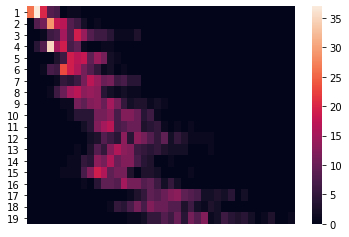

Mapa ciepła dla jednego czytnika


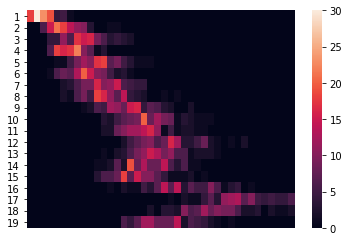

In [92]:
lambdas= [i for i in range(1, 21)]
heatmap_const_N(lambdas, 100)

Można zauważyć, że im większy parametr lambda tym bardziej przesunięte w prawo jest największe zagęszczenie czasów. Oznacza to, że wielkość parametru lambda jest proporcjonalna do czasu potrzebnego na odczytanie danych z dysku.

### Mapa ciepła dla stałej wartości parametru lambda
oraz rozmiarów dysku ze zbioru $\{50, 100, \ldots, 500\}$ i wartości parametru lambda $\lambda=3$

Mapa ciepła dla dwóch czytników


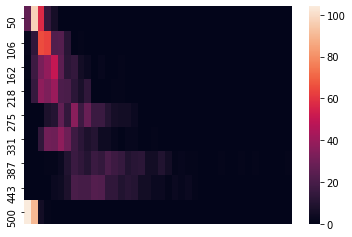

Mapa ciepła dla jednego czytnika


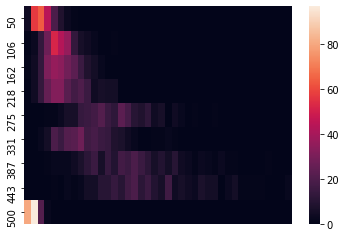

In [106]:
N = np.linspace(50, 500, 9, dtype=int)
heatmap_const_l(3, N)

Po raz kolejny zgodnie z naszymi oczekiwaniami im większy jest rozmiar dysku tym dłuższy jest czas potrzebny na zczytanie z niego danych.

### Histogramy oraz podstawowe statystyki 

Histogram dla lambd ze zbioru $\{1, \ldots, 5\}$ oraz wielkości dysku $N=100$:

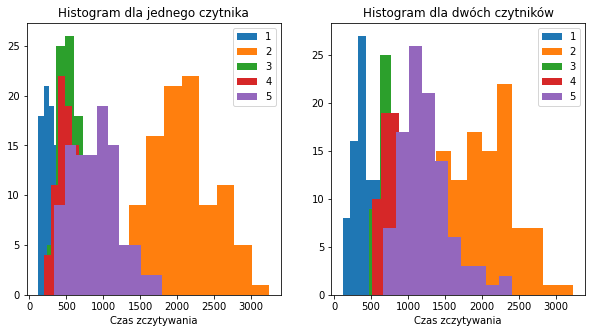

In [111]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()

lambdas1= [i for i in range(1, 6)]
a = hist_const_N(lambdas1, 100, df1, df2)

Histogram dla lambd ze zbioru $\{6, \ldots, 10\}$ oraz wielkości dysku $N=100$:

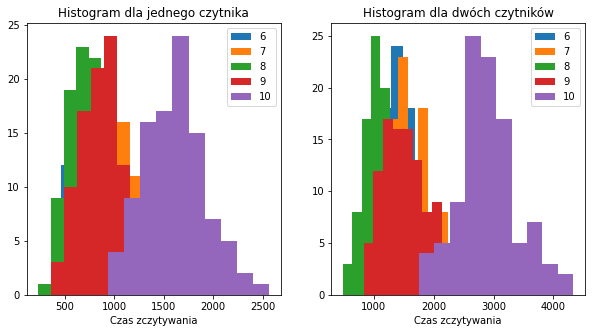

In [110]:
lambdas2= [i for i in range(6, 11)]
b = hist_const_N(lambdas2, 100, a[0], a[1])

Histogram dla lambd ze zbioru $\{11, \ldots, 15\}$ oraz wielkości dysku $N=100$:

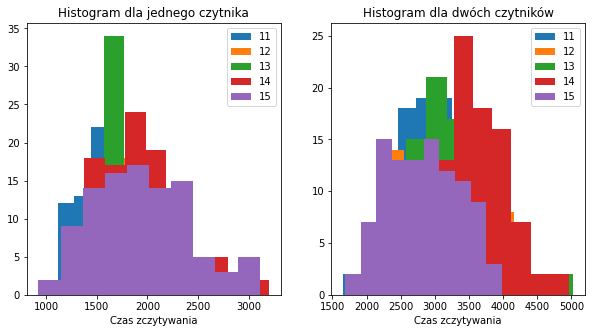

In [112]:
lambdas3= [i for i in range(11, 16)]
c = hist_const_N(lambdas3, 100, b[0], b[1])

Histogram dla lambd ze zbioru $\{16, \ldots, 20\}$ oraz wielkości dysku $N=100$:

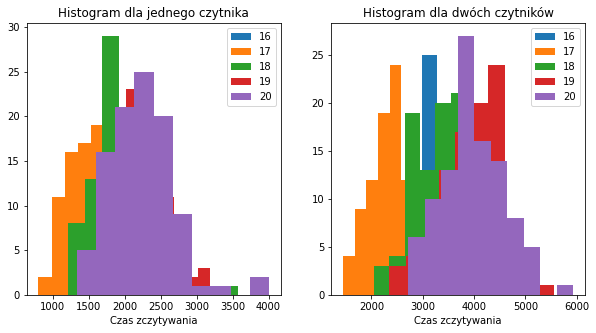

In [113]:
lambdas4= [i for i in range(16, 21)]
d = hist_const_N(lambdas4, 100, c[0], c[1])

Podstawowe statystyki opisowe (wariancja, średnia, odchylenie standardowe) dla lambdy z przedziału $\{1, \ldots ,20\}$ dla 100 symulowanych prób dla każdej $\lambda$ oraz $N=100$

In [114]:
print("Postawowe statystyki dla dwóch czytników")
print(d[0])
print("Podstatowe statystyki dla jednego czytnika")
print(d[1])

Postawowe statystyki dla dwóch czytników
    lambda     mean  standard deviation          var
0      1.0   359.06          182.425208   33278.9564
1      2.0   332.86          157.702379   24870.0404
2      3.0   570.94          198.277625   39314.0164
3      4.0   545.50          196.926306   38779.9700
4      5.0   870.77          245.225727   60135.6571
5      6.0   893.63          275.063907   75660.1531
6      7.0  1072.21          321.001162  103041.7459
7      8.0   759.01          239.773122   57491.1499
8      9.0   894.20          244.228213   59647.4200
9     10.0  1613.55          312.616358   97728.9875
10    11.0  1661.87          339.361007  115165.8931
11    12.0  1745.11          338.660151  114690.6979
12    13.0  1810.44          344.018032  118348.4064
13    14.0  1930.82          386.304993  149231.5476
14    15.0  1942.26          478.029092  228511.8124
15    16.0  2055.96          404.176172  163358.3784
16    17.0  1579.03          364.174009  132622.7091
17   

Wizualizacja danych przedstawionych w tabeli powyżej:

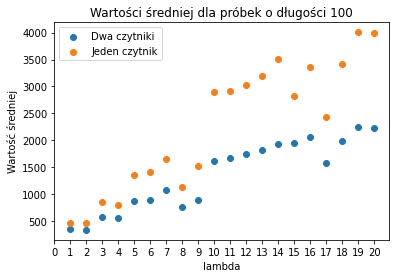

In [122]:
plt.scatter(d[0]["lambda"], d[0]["mean"])
plt.scatter(d[1]["lambda"], d[1]["mean"])
plt.title("Wartości średniej dla próbek o długości 100")
plt.legend(["Dwa czytniki", "Jeden czytnik"])
plt.xlabel("lambda")
plt.ylabel("Wartość średniej")
plt.xticks(range(21))
plt.show()

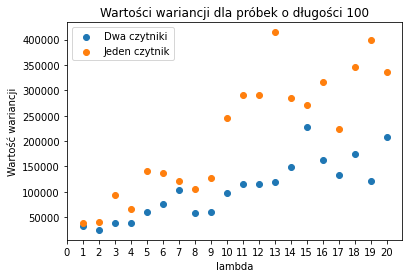

In [123]:
plt.scatter(d[0]["lambda"], d[0]["var"])
plt.scatter(d[1]["lambda"], d[1]["var"])
plt.title("Wartości wariancji dla próbek o długości 100")
plt.legend(["Dwa czytniki", "Jeden czytnik"])
plt.xlabel("lambda")
plt.ylabel("Wartość wariancji")
plt.xticks(range(21))
plt.show()

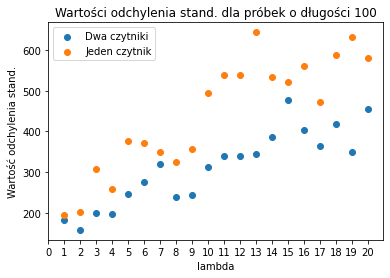

In [124]:
plt.scatter(d[0]["lambda"], d[0]["standard deviation"])
plt.scatter(d[1]["lambda"], d[1]["standard deviation"])
plt.title("Wartości odchylenia stand. dla próbek o długości 100")
plt.legend(["Dwa czytniki", "Jeden czytnik"])
plt.xlabel("lambda")
plt.ylabel("Wartość odchylenia stand.")
plt.xticks(range(21))
plt.show()

Tendencje są bardzo podobne do tych opisanych pod mapami ciepła. Należy jednak pamiętać o tym, że aby zapewnić sensowne czasy wykonania programu wielkość naszej próby dla każdego z parametrów wynosi jedynie 100. Odstępstwa od oczekiwanych przez nas wartości są więc możliwe i należy się ich spodziewać w ograniczonej ilości.

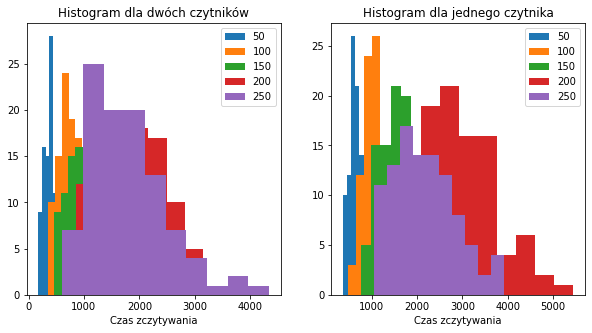

In [16]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()

N1= np.arange(50, 300, 50)
a = hist_const_l(N1, 5, df1, df2)

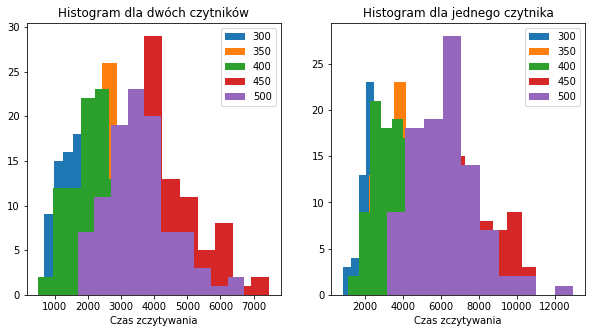

In [17]:
N2= np.arange(300, 550, 50)
b = hist_const_l(N2, 5, a[0], a[1])

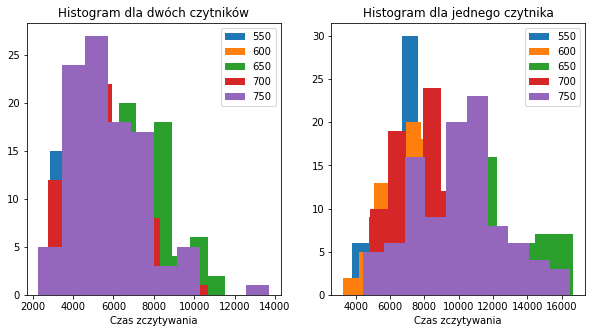

In [19]:
N3= np.arange(550, 800, 50)
c = hist_const_l(N3, 5, b[0], b[1])

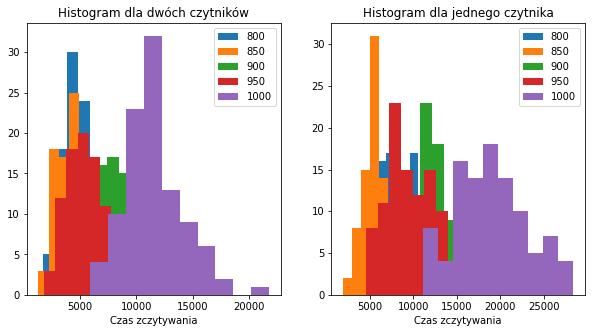

In [21]:
N4= np.arange(800, 1050, 50)
d = hist_const_l(N4, 5, c[0], c[1])

Podobnie jak z mapy ciepła możemy wywnioskować iż rozmiar dysku jest proporcjonalny do czasu zczytywania z niego danych. Nie jest to zaskoczeniem, ponieważ w tej sytuacji losując pozycje mamy mniejsze prawdopodobieństwo, że uda nam się trafić w odpowiednią z nich.

In [22]:
print("Postawowe statystyki dla dwóch czytników")
print(d[0])
print("Podstatowe statystyki dla jednego czytnika")
print(d[1])

Postawowe statystyki dla dwóch czytników
         N      mean  standard deviation           var
0     50.0    403.97          120.602442  1.454495e+04
1    100.0    760.35          238.168234  5.672411e+04
2    150.0    979.48          292.870944  8.577339e+04
3    200.0   1903.24          599.580472  3.594967e+05
4    250.0   1796.94          707.388038  5.003978e+05
5    300.0   1822.86          678.508232  4.603734e+05
6    350.0   2886.33          952.986191  9.081827e+05
7    400.0   2306.65          819.928050  6.722820e+05
8    450.0   4227.48         1067.594890  1.139759e+06
9    500.0   3566.31         1002.929257  1.005867e+06
10   550.0   5358.23         1685.251428  2.840072e+06
11   600.0   5197.29         1464.875000  2.145859e+06
12   650.0   7041.78         1726.539809  2.980940e+06
13   700.0   5629.35         1678.274861  2.816607e+06
14   750.0   5758.65         1799.067889  3.236645e+06
15   800.0   4941.54         1681.767793  2.828343e+06
16   850.0   4634.14    

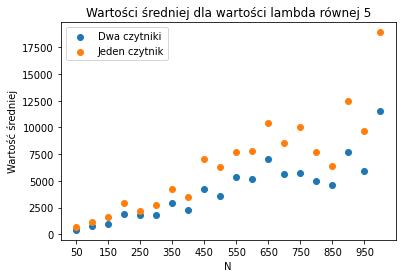

In [27]:
plt.scatter(d[0]["N"], d[0]["mean"])
plt.scatter(d[1]["N"], d[1]["mean"])
plt.title("Wartości średniej dla wartości lambda równej 5")
plt.legend(["Dwa czytniki", "Jeden czytnik"])
plt.xlabel("N")
plt.ylabel("Wartość średniej")
plt.xticks(range(50, 1050, 100))
plt.show()

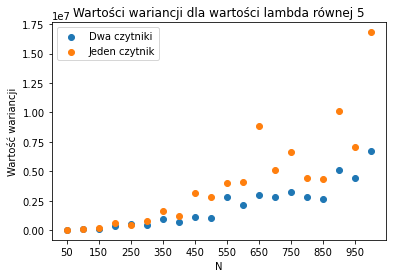

In [30]:
plt.scatter(d[0]["N"], d[0]["var"])
plt.scatter(d[1]["N"], d[1]["var"])
plt.title("Wartości wariancji dla wartości lambda równej 5")
plt.legend(["Dwa czytniki", "Jeden czytnik"])
plt.xlabel("N")
plt.ylabel("Wartość wariancji")
plt.xticks(range(50, 1050, 100))
plt.show()

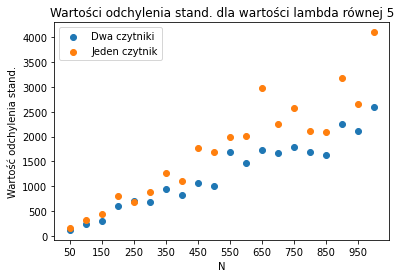

In [29]:
plt.scatter(d[0]["N"], d[0]["standard deviation"])
plt.scatter(d[1]["N"], d[1]["standard deviation"])
plt.title("Wartości odchylenia stand. dla wartości lambda równej 5")
plt.legend(["Dwa czytniki", "Jeden czytnik"])
plt.xlabel("N")
plt.ylabel("Wartość odchylenia stand.")
plt.xticks(range(50, 1050, 100))
plt.show()

Widzimy, że zarówno wartości średniej, wariancji oraz odchylenia standardowego są większe dla przypadku w którym mamy tylko jeden czytnik

## Analiza czasu zczytywania dla wielkości plików z katalogu głównego Pythona

Myśląc o wygenerowaniu próbki z rozkładu zadanego próbą losową przeszło mi przez myśl kilka możliwości. Jedną z nich było wyznaczenie gęstości empirycznej na podstawie próbki losowej oraz wykorzystanie metody akceptacji odrzucenia. Innym pomysłem było wykorzystanie metody odwrotnej dystrybuanty. Zorientowałam się jednakże, że dla próby losowej metoda odwrotnej dystrybuanty sprowadza się do losowania wartości z próby, jest to również metoda która zapewnia najmniejsze straty informacji, stąd też problem ten został przede mnie rozwiązany w ten właśnie sposób.

In [139]:
def files_from_F(N, l=1):
    """Get N - number of iterations and optional argument lambda. N-times get two filesize
    from size_list (python files directory) and put them on disc. Draws histogram of times 
    of reading the files from drive as well as a cumulative distibution function's plot for 
    this data."""
    size_list = get_size(scale=0.05, max_val=10000)[1]
    val1 = []
    val2 = []
    for i in range(N):
        c = R.random_int(2, 0, len(size_list)-1)
        m1 = int(size_list[c[0]])
        m2 = int(size_list[c[1]])
        while m1 == 0 or m2 == 0:
            c = R.random_int(2, 0, len(size_list)-1)
            m1 = int(size_list[c[0]])
            m2 = int(size_list[c[1]])

        P1 = part_file(m=m1, l=l)
        P2 = part_file(neg=True, m=m2, l=l)
        
        d = put_on_drive(int((m1 + m2)/0.4), P1, P2)
        val1.append(read_from_drive(d))
        val2.append(read_from_drive(d, both=False))
    
    plt.hist(val1)
    plt.title("Hist. czasów dla rozmiarów plików z katalgou pythona i l=%s" % l, pad=15)
    plt.xlabel("Czasy zczytywania")
    plt.show()
    drawdemp(val1, title="Dyst. czasów dla rozmiarów plików z katalgou pythona i l=%s" % l)

Poniżej przedstawiam przykład wywołania powyższej funkcji: narysowane zostały unormowane histogramy oraz dystrybuanty empiryczne dla stu próbek wygenerowanych z rozkładu proporcjonalnego do rozkładu plików w katalogu pythona.

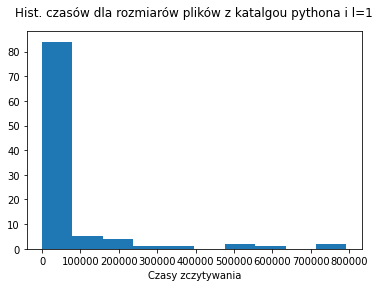

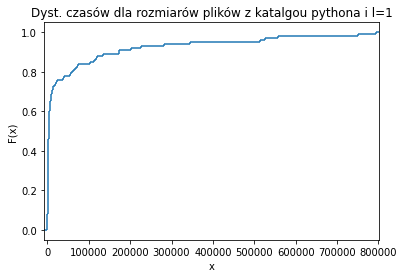

In [140]:
files_from_F(100, l=1)

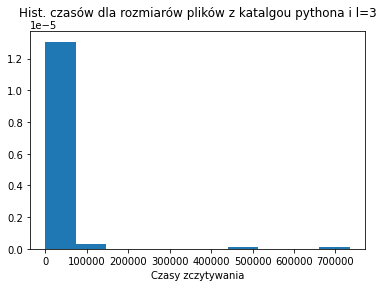

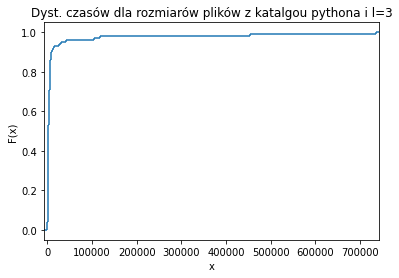

In [138]:
files_from_F(100, l=3)

## Wnioski
Nawet z tak prostego modelu jak ten zaproponowany przeze mnie da się wyciągąć pewną naukę. Widać, że gdy losowo odczytujemy pliki z dysku ilość podziałów będzie wpływała negatywnie na czas niezbędny do tego. Również wraz ze wzrostem wielkości dysku czasy te rosną. Dalej możnaby zastanowić się w jaki sposób wybierane przez nas struktury danych w konkretnych sytuacjach mogą negatywnie wpływać na działanie naszych programów.